In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

from datetime import datetime
import math

from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
dscovr_data = {}
for file in os.listdir("/kaggle/input/dscovr-data"):
    if file.count("dsc"):
        dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]

/tmp/ipykernel_27/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_27/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_27/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dscovr_data["yr_"+file.split("_")[4]] = pd.read_csv(os.path.join("/kaggle/input/dscovr-data", file), index_col=False).iloc[1:]
/tmp/ipykernel_27/3663265967.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data wit

In [58]:
for key in dscovr_data.keys():
    dscovr_data[key]["DOY"] = dscovr_data[key]["Date"].apply(lambda x: int(datetime.fromisoformat(x).timetuple().tm_yday))
    dscovr_data[key]["YEAR"] = dscovr_data[key]["Date"].apply(lambda x: int(datetime.fromisoformat(x).year))
    dscovr_data[key]["HR"] = dscovr_data[key]["Time"].apply(lambda x: int(x.split(":")[0])+int(x.split(":")[1])/60)
    dscovr_data[key]["Bt"] = np.sum(dscovr_data[key][["Bx", "By", "Bz"]]**2, axis=1)**0.5
    
    dscovr_data[key] = dscovr_data[key].drop(columns=["Date", "Time"])

KeyError: 'Date'

In [59]:
kp_data = pd.read_csv("/kaggle/input/dscovr-data/kP_index_data.csv")
kp_data["HR"] = kp_data["HR"].apply(lambda x: float(x))
kp_data["kP"] = kp_data["kP"].apply(lambda x: x/10)

In [60]:
kp_data.iloc[:20]

,YEAR,DOY,HR,kP
0,2016,1,0.0,6.0
1,2016,1,1.0,6.0
2,2016,1,2.0,6.0
3,2016,1,3.0,5.3
4,2016,1,4.0,5.3
5,2016,1,5.0,5.3
6,2016,1,6.0,5.0
7,2016,1,7.0,5.0
8,2016,1,8.0,5.0
9,2016,1,9.0,3.3


# Naive Time Series Classification

In [73]:
def sliding_window(window_size, x_split, jump, index):
    full_window = np.arange(jump*index, window_size+jump*index)
    x_idxs = full_window[:x_split]
    y_idxs = full_window[x_split:]
    
    return x_idxs, y_idxs
    
class ForecastingDataset(Dataset):
    def __init__(self, data, window_size = 360, x_split = 240, jump=60):
        self.idx_length = (len(data)-window_size)//jump + 1
        
        self.data = data
        self.window_size = window_size
        self.x_split = x_split
        self.jump = jump
        
    def __len__(self):
        return self.idx_length
    
    def __getitem__(self, idx):
        x_idxs, y_idxs = sliding_window(self.window_size, self.x_split, self.jump, idx)
        
        return self.data.iloc[x_idxs], self.data.iloc[y_idxs]
    
class kPPredictionDataset(Dataset):
    def __init__(self, discovr_data, kp_data, window_size = 12*60, x_split = 12*60-60, jump=180):
        self.idx_length = (len(discovr_data)-window_size)//jump + 1
        
        self.discovr_data = discovr_data
        self.kp_data = kp_data
        self.window_size = window_size
        self.x_split = x_split
        self.jump = jump
        
    def __len__(self):
        return self.idx_length
    
    def __getitem__(self, idx):
        x_idxs, y_idxs = sliding_window(self.window_size, self.x_split, self.jump, idx)
        y_kp = []
        for idx, row in self.discovr_data.iloc[y_idxs][::-60][::-1].iterrows():
            year = row["YEAR"]
            doy = row["DOY"]
            hour = row["HR"]
            y_kp.append(kp_data[(kp_data["HR"]==hour) & (kp_data["DOY"]==doy) & (kp_data["YEAR"]==year)].drop(columns=["YEAR", "DOY", "HR"]).to_numpy())
        
        return torch.tensor(self.discovr_data.iloc[x_idxs].drop(columns=["YEAR", "HR"])[["DOY", "Bt", "Bx", "By", "Bz"]].to_numpy()), torch.tensor(np.stack(y_kp))

In [74]:
kp_ds = kPPredictionDataset(dscovr_data["yr_2023"], kp_data[kp_data["YEAR"]==2023])
train_set, val_set = torch.utils.data.random_split(kp_ds, [int(len(kp_ds)*0.75), int(len(kp_ds)-len(kp_ds)*0.75)])
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=16)
test_dataloader = DataLoader(train_set, shuffle=True, batch_size=16)

del kp_ds

In [75]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.bn = nn.BatchNorm1d(660)

    def forward(self, x):
        
        x = self.bn(x)
        
        h_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device)
        
        c_0 = torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [76]:
kP_model = LSTM(1, 5, 256, 1).to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(kP_model.parameters(), lr=0.01)

In [77]:
loss_vals = []

kP_model.train()

for epoch in range(200):
    total_loss = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader)):
        x = torch.nan_to_num(x).to(device).float()
        y = torch.nan_to_num(y).to(device).float().squeeze(-1).squeeze(-1)
        
        outputs = kP_model(x)

        # obtain the loss function
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        total_loss+=loss.item()
    
    loss_vals.append(total_loss/182)
    print(f"epoch: {epoch}, total loss: {total_loss}")
    
kP_model.eval()

46it [00:03, 12.59it/s]


epoch: 0, total loss: 113.57358026504517


46it [00:03, 12.84it/s]


epoch: 1, total loss: 86.32505816221237


46it [00:03, 13.19it/s]


epoch: 2, total loss: 82.54674428701401


46it [00:03, 13.03it/s]


epoch: 3, total loss: 66.85191476345062


46it [00:03, 13.24it/s]


epoch: 4, total loss: 64.53977143764496


46it [00:03, 13.26it/s]


epoch: 5, total loss: 59.554649740457535


46it [00:03, 11.67it/s]


epoch: 6, total loss: 54.2856612354517


46it [00:03, 12.98it/s]


epoch: 7, total loss: 52.2335501909256


46it [00:03, 13.02it/s]


epoch: 8, total loss: 57.69344222545624


46it [00:03, 12.92it/s]


epoch: 9, total loss: 52.50229340791702


46it [00:03, 13.02it/s]


epoch: 10, total loss: 52.20611268281937


46it [00:03, 13.22it/s]


epoch: 11, total loss: 54.912984400987625


46it [00:03, 13.01it/s]


epoch: 12, total loss: 52.84578049182892


46it [00:03, 13.18it/s]


epoch: 13, total loss: 51.70502361655235


46it [00:03, 13.20it/s]


epoch: 14, total loss: 49.907271295785904


46it [00:03, 11.79it/s]


epoch: 15, total loss: 52.33503246307373


46it [00:03, 13.05it/s]


epoch: 16, total loss: 51.860238909721375


46it [00:03, 12.92it/s]


epoch: 17, total loss: 52.766924023628235


46it [00:03, 13.15it/s]


epoch: 18, total loss: 53.66617852449417


46it [00:03, 13.15it/s]


epoch: 19, total loss: 54.485380709171295


46it [00:03, 12.90it/s]


epoch: 20, total loss: 52.16736829280853


46it [00:03, 13.20it/s]


epoch: 21, total loss: 54.03100237250328


46it [00:03, 13.21it/s]


epoch: 22, total loss: 52.51067227125168


46it [00:03, 12.96it/s]


epoch: 23, total loss: 52.53573668003082


46it [00:03, 11.56it/s]


epoch: 24, total loss: 49.38634234666824


46it [00:03, 12.56it/s]


epoch: 25, total loss: 49.49047839641571


46it [00:03, 12.40it/s]


epoch: 26, total loss: 54.336034059524536


46it [00:03, 12.79it/s]


epoch: 27, total loss: 50.998691499233246


46it [00:03, 12.94it/s]


epoch: 28, total loss: 52.008722960948944


46it [00:03, 12.81it/s]


epoch: 29, total loss: 48.34764164686203


46it [00:03, 12.70it/s]


epoch: 30, total loss: 48.9249302148819


46it [00:03, 12.77it/s]


epoch: 31, total loss: 49.77151733636856


46it [00:03, 11.88it/s]


epoch: 32, total loss: 50.37277972698212


46it [00:03, 12.27it/s]


epoch: 33, total loss: 47.24642449617386


46it [00:03, 12.73it/s]


epoch: 34, total loss: 48.305871069431305


46it [00:03, 13.09it/s]


epoch: 35, total loss: 48.385240495204926


46it [00:03, 13.20it/s]


epoch: 36, total loss: 48.91640970110893


46it [00:03, 12.91it/s]


epoch: 37, total loss: 47.383893966674805


46it [00:03, 13.14it/s]


epoch: 38, total loss: 49.19181677699089


46it [00:03, 13.19it/s]


epoch: 39, total loss: 50.681443482637405


46it [00:03, 12.96it/s]


epoch: 40, total loss: 48.06046849489212


46it [00:03, 11.52it/s]


epoch: 41, total loss: 48.5930370092392


46it [00:03, 12.43it/s]


epoch: 42, total loss: 50.90403884649277


46it [00:03, 12.82it/s]


epoch: 43, total loss: 49.72147220373154


46it [00:03, 12.81it/s]


epoch: 44, total loss: 49.72457563877106


46it [00:03, 12.93it/s]


epoch: 45, total loss: 46.563325852155685


46it [00:03, 13.09it/s]


epoch: 46, total loss: 47.52178394794464


46it [00:03, 13.07it/s]


epoch: 47, total loss: 49.25268158316612


46it [00:03, 13.01it/s]


epoch: 48, total loss: 51.82121694087982


46it [00:03, 12.97it/s]


epoch: 49, total loss: 47.1108278632164


46it [00:03, 11.89it/s]


epoch: 50, total loss: 47.86869326233864


46it [00:03, 12.95it/s]


epoch: 51, total loss: 47.4687893986702


46it [00:03, 13.05it/s]


epoch: 52, total loss: 43.05870655179024


46it [00:03, 12.87it/s]


epoch: 53, total loss: 42.603692799806595


46it [00:03, 13.19it/s]


epoch: 54, total loss: 45.18614512681961


46it [00:03, 13.24it/s]


epoch: 55, total loss: 47.54826259613037


46it [00:03, 12.99it/s]


epoch: 56, total loss: 42.48510184884071


46it [00:03, 13.20it/s]


epoch: 57, total loss: 40.93905660510063


46it [00:03, 12.90it/s]


epoch: 58, total loss: 41.94056349992752


46it [00:03, 11.70it/s]


epoch: 59, total loss: 44.20142075419426


46it [00:03, 13.17it/s]


epoch: 60, total loss: 45.02730467915535


46it [00:03, 13.07it/s]


epoch: 61, total loss: 43.97297993302345


46it [00:03, 12.90it/s]


epoch: 62, total loss: 42.100849986076355


46it [00:03, 13.22it/s]


epoch: 63, total loss: 41.58635151386261


46it [00:03, 13.18it/s]


epoch: 64, total loss: 41.90400305390358


46it [00:03, 13.13it/s]


epoch: 65, total loss: 41.72765216231346


46it [00:03, 13.08it/s]


epoch: 66, total loss: 41.675756752491


46it [00:03, 13.08it/s]


epoch: 67, total loss: 44.40374931693077


46it [00:03, 11.62it/s]


epoch: 68, total loss: 41.831239461898804


46it [00:03, 13.14it/s]


epoch: 69, total loss: 42.2618610560894


46it [00:03, 12.99it/s]


epoch: 70, total loss: 39.28899163007736


46it [00:03, 13.29it/s]


epoch: 71, total loss: 40.868727058172226


46it [00:03, 13.23it/s]


epoch: 72, total loss: 40.07469066977501


46it [00:03, 13.08it/s]


epoch: 73, total loss: 38.63867938518524


46it [00:03, 13.05it/s]


epoch: 74, total loss: 41.04385221004486


46it [00:03, 12.92it/s]


epoch: 75, total loss: 39.34787172079086


46it [00:03, 13.06it/s]


epoch: 76, total loss: 38.38525462150574


46it [00:03, 11.93it/s]


epoch: 77, total loss: 37.5802286863327


46it [00:03, 13.26it/s]


epoch: 78, total loss: 42.395862460136414


46it [00:03, 13.10it/s]


epoch: 79, total loss: 36.76567268371582


46it [00:03, 13.26it/s]


epoch: 80, total loss: 38.39758671820164


46it [00:03, 13.27it/s]


epoch: 81, total loss: 41.077628791332245


46it [00:03, 13.09it/s]


epoch: 82, total loss: 36.92851832509041


46it [00:03, 12.96it/s]


epoch: 83, total loss: 35.62171366810799


46it [00:03, 12.97it/s]


epoch: 84, total loss: 35.30323329567909


46it [00:03, 13.33it/s]


epoch: 85, total loss: 38.36445337533951


46it [00:03, 11.96it/s]


epoch: 86, total loss: 39.15283314883709


46it [00:03, 12.94it/s]


epoch: 87, total loss: 38.089544117450714


46it [00:03, 13.24it/s]


epoch: 88, total loss: 38.47728079557419


46it [00:03, 13.29it/s]


epoch: 89, total loss: 36.008544743061066


46it [00:03, 13.05it/s]


epoch: 90, total loss: 35.18828046321869


46it [00:03, 13.11it/s]


epoch: 91, total loss: 35.47732648253441


46it [00:03, 13.04it/s]


epoch: 92, total loss: 36.88161739706993


46it [00:03, 13.13it/s]


epoch: 93, total loss: 35.58389391005039


46it [00:03, 13.22it/s]


epoch: 94, total loss: 34.757039695978165


46it [00:03, 11.86it/s]


epoch: 95, total loss: 36.15628868341446


46it [00:03, 12.50it/s]


epoch: 96, total loss: 35.54027655720711


46it [00:03, 12.85it/s]


epoch: 97, total loss: 33.54228438436985


46it [00:03, 12.61it/s]


epoch: 98, total loss: 37.47832489013672


46it [00:03, 12.78it/s]


epoch: 99, total loss: 35.18742063641548


46it [00:03, 12.73it/s]


epoch: 100, total loss: 36.27496778964996


46it [00:03, 12.56it/s]


epoch: 101, total loss: 32.88859358429909


46it [00:03, 12.81it/s]


epoch: 102, total loss: 32.65255717933178


46it [00:03, 11.76it/s]


epoch: 103, total loss: 36.309302031993866


46it [00:03, 12.57it/s]


epoch: 104, total loss: 38.708974212408066


46it [00:03, 12.84it/s]


epoch: 105, total loss: 34.616828829050064


46it [00:03, 12.79it/s]


epoch: 106, total loss: 33.30751657485962


46it [00:03, 12.61it/s]


epoch: 107, total loss: 33.770599991083145


46it [00:03, 12.73it/s]


epoch: 108, total loss: 35.454365253448486


46it [00:03, 12.50it/s]


epoch: 109, total loss: 35.160772293806076


46it [00:03, 12.86it/s]


epoch: 110, total loss: 36.35466289520264


46it [00:03, 12.75it/s]


epoch: 111, total loss: 35.03864401578903


46it [00:04, 11.44it/s]


epoch: 112, total loss: 35.178298234939575


46it [00:03, 13.24it/s]


epoch: 113, total loss: 33.06096786260605


46it [00:03, 13.17it/s]


epoch: 114, total loss: 36.27102181315422


46it [00:03, 13.02it/s]


epoch: 115, total loss: 35.424302875995636


46it [00:03, 12.95it/s]


epoch: 116, total loss: 33.81191462278366


46it [00:03, 13.07it/s]


epoch: 117, total loss: 33.216314911842346


46it [00:03, 12.97it/s]


epoch: 118, total loss: 33.591615200042725


46it [00:03, 13.19it/s]


epoch: 119, total loss: 34.126230686903


46it [00:03, 12.87it/s]


epoch: 120, total loss: 35.40008985996246


46it [00:03, 11.90it/s]


epoch: 121, total loss: 32.238921612501144


46it [00:03, 13.13it/s]


epoch: 122, total loss: 31.311705991625786


46it [00:03, 12.99it/s]


epoch: 123, total loss: 32.618766874074936


46it [00:03, 13.14it/s]


epoch: 124, total loss: 31.904108375310898


46it [00:03, 13.08it/s]


epoch: 125, total loss: 32.6380762308836


46it [00:03, 12.82it/s]


epoch: 126, total loss: 30.791492998600006


46it [00:03, 13.18it/s]


epoch: 127, total loss: 30.854380398988724


46it [00:03, 13.13it/s]


epoch: 128, total loss: 33.71364325284958


46it [00:03, 12.99it/s]


epoch: 129, total loss: 38.70866098999977


46it [00:03, 11.77it/s]


epoch: 130, total loss: 32.67918610572815


46it [00:03, 12.71it/s]


epoch: 131, total loss: 31.56218409538269


46it [00:03, 12.53it/s]


epoch: 132, total loss: 33.208701342344284


46it [00:03, 12.45it/s]


epoch: 133, total loss: 31.82418856024742


46it [00:03, 12.86it/s]


epoch: 134, total loss: 31.29283106327057


46it [00:03, 13.19it/s]


epoch: 135, total loss: 31.54639369249344


46it [00:03, 13.27it/s]


epoch: 136, total loss: 31.677194893360138


46it [00:03, 13.01it/s]


epoch: 137, total loss: 29.416652143001556


46it [00:03, 12.73it/s]


epoch: 138, total loss: 29.460114389657974


46it [00:03, 12.61it/s]


epoch: 139, total loss: 30.875108674168587


46it [00:03, 13.10it/s]


epoch: 140, total loss: 32.95393446087837


46it [00:03, 13.16it/s]


epoch: 141, total loss: 29.90988317131996


46it [00:03, 13.20it/s]


epoch: 142, total loss: 30.168222069740295


46it [00:03, 12.96it/s]


epoch: 143, total loss: 28.50836604833603


46it [00:03, 13.20it/s]


epoch: 144, total loss: 28.20354636013508


46it [00:03, 13.15it/s]


epoch: 145, total loss: 27.883452460169792


46it [00:03, 13.02it/s]


epoch: 146, total loss: 27.69861351698637


46it [00:03, 12.33it/s]


epoch: 147, total loss: 31.3235704600811


46it [00:03, 12.37it/s]


epoch: 148, total loss: 33.79449689388275


46it [00:03, 13.25it/s]


epoch: 149, total loss: 165.17746978998184


46it [00:03, 13.25it/s]


epoch: 150, total loss: 73.52262461185455


46it [00:03, 12.90it/s]


epoch: 151, total loss: 61.726716220378876


46it [00:03, 13.31it/s]


epoch: 152, total loss: 58.55146944522858


46it [00:03, 13.19it/s]


epoch: 153, total loss: 60.41324323415756


46it [00:03, 13.08it/s]


epoch: 154, total loss: 57.332323014736176


46it [00:03, 13.32it/s]


epoch: 155, total loss: 54.269085109233856


46it [00:03, 12.42it/s]


epoch: 156, total loss: 56.469888389110565


46it [00:03, 12.72it/s]


epoch: 157, total loss: 53.17576974630356


46it [00:03, 13.25it/s]


epoch: 158, total loss: 58.560880959033966


46it [00:03, 13.18it/s]


epoch: 159, total loss: 52.338317811489105


46it [00:03, 12.79it/s]


epoch: 160, total loss: 54.814182102680206


46it [00:03, 13.28it/s]


epoch: 161, total loss: 53.223749339580536


46it [00:03, 13.21it/s]


epoch: 162, total loss: 52.5630159676075


46it [00:03, 13.14it/s]


epoch: 163, total loss: 61.60549110174179


46it [00:03, 13.26it/s]


epoch: 164, total loss: 52.69869214296341


46it [00:03, 11.89it/s]


epoch: 165, total loss: 55.99959123134613


46it [00:03, 13.05it/s]


epoch: 166, total loss: 48.77096405625343


46it [00:03, 13.19it/s]


epoch: 167, total loss: 56.07589441537857


46it [00:03, 13.15it/s]


epoch: 168, total loss: 59.25905954837799


46it [00:03, 13.06it/s]


epoch: 169, total loss: 52.07960295677185


46it [00:03, 13.33it/s]


epoch: 170, total loss: 55.01627603173256


46it [00:03, 12.97it/s]


epoch: 171, total loss: 55.435371935367584


46it [00:03, 13.26it/s]


epoch: 172, total loss: 54.28258091211319


46it [00:03, 13.37it/s]


epoch: 173, total loss: 52.120183140039444


46it [00:03, 11.93it/s]


epoch: 174, total loss: 53.139891147613525


46it [00:03, 13.13it/s]


epoch: 175, total loss: 52.32993794977665


46it [00:03, 13.30it/s]


epoch: 176, total loss: 50.39417523145676


46it [00:03, 12.88it/s]


epoch: 177, total loss: 53.95012837648392


46it [00:03, 13.19it/s]


epoch: 178, total loss: 51.38826406002045


46it [00:03, 13.19it/s]


epoch: 179, total loss: 50.4144150018692


46it [00:03, 13.25it/s]


epoch: 180, total loss: 48.167251884937286


46it [00:03, 13.22it/s]


epoch: 181, total loss: 51.33901655673981


46it [00:03, 13.12it/s]


epoch: 182, total loss: 50.42372491955757


46it [00:03, 11.94it/s]


epoch: 183, total loss: 48.246385365724564


46it [00:03, 13.25it/s]


epoch: 184, total loss: 51.78988108038902


46it [00:03, 13.09it/s]


epoch: 185, total loss: 59.89996273815632


46it [00:03, 13.13it/s]


epoch: 186, total loss: 50.02207791805267


46it [00:03, 13.16it/s]


epoch: 187, total loss: 49.280211329460144


46it [00:03, 13.01it/s]


epoch: 188, total loss: 48.670293778181076


46it [00:03, 13.24it/s]


epoch: 189, total loss: 48.36345440149307


46it [00:03, 13.24it/s]


epoch: 190, total loss: 52.706481873989105


46it [00:03, 13.14it/s]


epoch: 191, total loss: 50.6679253578186


46it [00:03, 12.02it/s]


epoch: 192, total loss: 55.98461639881134


46it [00:03, 13.21it/s]


epoch: 193, total loss: 50.36745262145996


46it [00:03, 13.09it/s]


epoch: 194, total loss: 59.58984073996544


46it [00:03, 13.17it/s]


epoch: 195, total loss: 50.53438088297844


46it [00:03, 13.09it/s]


epoch: 196, total loss: 54.06937301158905


46it [00:03, 13.23it/s]


epoch: 197, total loss: 54.1468371450901


46it [00:03, 13.31it/s]


epoch: 198, total loss: 50.99775651097298


46it [00:03, 13.16it/s]

epoch: 199, total loss: 58.360756039619446


LSTM(
  (lstm): LSTM(5, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (bn): BatchNorm1d(660, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [80]:
kP_real = np.stack([train_set[idx][1][0, 0, 0].numpy() for idx in range(len(train_set))])
kP_real

array([6.7, 4.7, 0.7, 1.7, 0.3, 0.3, 3.3, 1.3, 0.3, 1.7, 1.7, 0.3, 2. ,
       1.3, 0.7, 4.3, 2. , 2. , 1. , 2.7, 2.7, 4.7, 0.7, 1.3, 3.3, 2. ,
       1.3, 2.7, 1.7, 3.7, 1.3, 1.7, 3. , 2. , 2. , 4.3, 3.3, 2. , 2. ,
       0. , 5.7, 4.7, 3.7, 2.7, 3. , 2.3, 0. , 0.3, 2. , 1.7, 1.7, 0.3,
       2. , 1. , 2.7, 1. , 0.7, 2.7, 8. , 1. , 1. , 1.7, 2.3, 0.7, 3.7,
       0.7, 4.3, 3.7, 2.3, 3.3, 4. , 2. , 2.3, 2. , 2. , 3.7, 1.3, 1. ,
       3. , 1.3, 0.7, 4. , 3.3, 2. , 1.3, 1.3, 1.7, 2.7, 0. , 0.7, 1.7,
       6.7, 1.7, 1. , 1. , 1.7, 0.7, 2.3, 1. , 2.3, 1.7, 1.3, 0.3, 1. ,
       3. , 2.3, 0.7, 3.7, 3.3, 3.3, 1.3, 2.3, 1.7, 1.7, 2. , 2.3, 3.3,
       3.3, 2. , 1.7, 3. , 3.7, 2. , 3.3, 3. , 0.3, 1.3, 0.3, 0.3, 2. ,
       0.7, 1. , 6.3, 2. , 2. , 0.7, 0.3, 4. , 0. , 4. , 1.3, 1.3, 0.3,
       2.7, 3.3, 1.3, 2.7, 1. , 2.7, 1.3, 0.7, 1.7, 3.7, 5.3, 0.3, 3. ,
       1. , 0.7, 4. , 0.7, 3. , 3.3, 2.7, 2.3, 2.7, 0. , 2.7, 2. , 7. ,
       2. , 1. , 2.3, 2.7, 4.3, 1. , 1.7, 1.7, 2. , 2. , 1.3, 4.

In [78]:
with torch.no_grad():
    kP_pred = np.array([kP_model(torch.nan_to_num(train_set[idx][0]).unsqueeze(0).to(device).float()).item() for idx in tqdm(range(len(train_set)))])

100%|██████████| 729/729 [00:09<00:00, 74.17it/s]


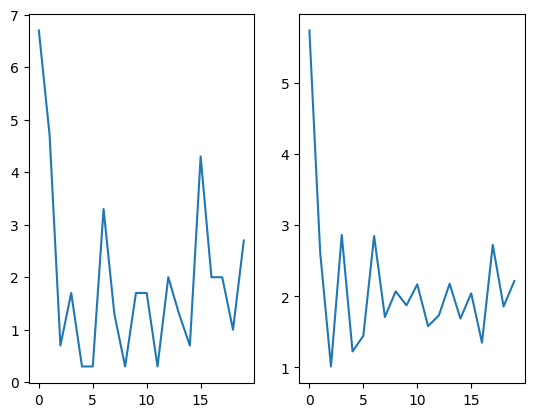

In [81]:
fig, ax = plt.subplots(ncols=2)
ax[0].plot(kP_real[:20])
ax[1].plot(kP_pred[:20])

# Predictions Based on Scalar B, Bx, By, Bz, Proton Density, Plasma Speed, and Flow Pressure

In [4]:
var_df = pd.read_csv("/kaggle/input/dscovr-data/correlated_vars.csv")

In [9]:
class ConversionDataset(Dataset):
    def __init__(self, data_df, input_columns = ["Bx", "By", "Bz"], output_columns = ["SWPD", "SWPS", "Fp"]):
        self.data = data_df
        self.input_columns = input_columns
        self.output_columns = output_columns
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx][self.input_columns]), torch.tensor(self.data.iloc[idx][self.output_columns])

In [6]:
class ConversionPredictor(nn.Module):

    def __init__(self, num_inputs, num_outputs, hidden_sizes = [32, 64, 128, 64]):
        super(ConversionPredictor, self).__init__()
        
        self.bn = nn.BatchNorm1d(3)
        
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_sizes = hidden_sizes
        
        self.input_layer = nn.Linear(num_inputs, hidden_sizes[0])
        
        hidden_layers = []
        for idx in range(len(hidden_sizes)-1):
            hidden_layers.append(nn.Linear(hidden_sizes[idx], hidden_sizes[idx+1]))
            hidden_layers.append(nn.ReLU())
            
        self.hidden = nn.Sequential(*hidden_layers)
        
        self.output_layer = nn.Linear(hidden_sizes[-1], num_outputs)

    def forward(self, x):
        
        x = self.bn(x)
        
        x = F.relu(self.input_layer(x))
        x = self.hidden(x)
        
        out = self.output_layer(x)
        
        return out

In [10]:
train_set, val_set = torch.utils.data.random_split(ConversionDataset(var_df, output_columns=["SWPD"]), [int(len(var_df)*0.8), len(ConversionDataset(var_df))-int(len(var_df)*0.8)])
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=128)
test_dataloader = DataLoader(train_set, shuffle=True, batch_size=128)

In [11]:
conv_pred = torch.nn.Linear(3, 1).to(device)
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(conv_pred.parameters(), lr=0.01)

In [23]:
loss_vals = []

conv_pred.train()

for epoch in range(10):
    total_loss = 0
    for i, (x, y) in tqdm(enumerate(train_dataloader)):
        x = x.to(device).float()
        y = y.to(device).float()
        
        outputs = conv_pred(x)

        # obtain the loss function
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        total_loss+=loss.item()
    
    loss_vals.append(total_loss/len(train_set))
    print(f"epoch: {epoch}, total loss: {total_loss/len(train_set)}")
    
conv_pred.eval()

402it [01:04,  6.25it/s]


epoch: 0, total loss: 46.52482881259748


402it [01:04,  6.25it/s]


epoch: 1, total loss: 46.51835877209895


402it [01:04,  6.28it/s]


epoch: 2, total loss: 46.33481880194366


402it [01:04,  6.27it/s]


epoch: 3, total loss: 46.44832006388165


402it [01:04,  6.28it/s]


epoch: 4, total loss: 46.5532939386772


402it [01:04,  6.27it/s]


epoch: 5, total loss: 46.473924830075006


402it [01:04,  6.27it/s]


epoch: 6, total loss: 46.490827807353696


402it [01:04,  6.27it/s]


epoch: 7, total loss: 46.64859893780139


402it [01:04,  6.27it/s]


epoch: 8, total loss: 46.1683730730531


402it [01:04,  6.27it/s]

epoch: 9, total loss: 46.64888680260274


Linear(in_features=3, out_features=1, bias=True)

(-2.0, 26.0)

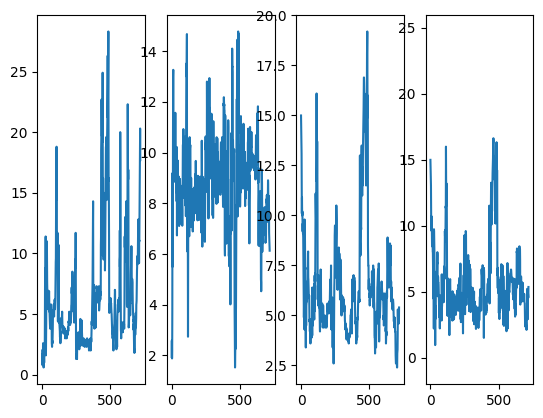

In [30]:
fig, ax = plt.subplots(ncols=4)
ax[0].plot(var_df["SWPD"][:12*60])
ax[1].plot(conv_pred(torch.tensor(var_df[["Bx", "By", "Bz"]].iloc[:12*60].to_numpy()).to(device).float()).squeeze().detach().cpu().numpy())
ax[2].plot(var_df["Bt"][:12*60])
ax[3].plot(np.sum(var_df[["Bx", "By", "Bz"]].iloc[:12*60]**2, axis=1)**0.5)
plt.ylim(-2, 26)
#ax[2].plot(var_df["By"][:12*60])
#ax[3].plot(var_df["Bx"][:12*60])

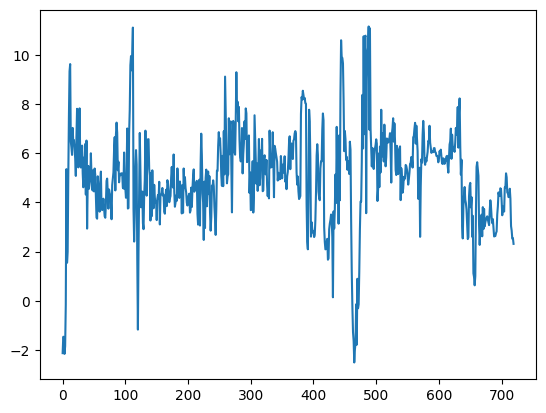

In [19]:
plt.plot(conv_pred(torch.tensor(var_df[["Bx", "By", "Bz"]].iloc[:12*60].to_numpy()).to(device).float()).squeeze().detach().cpu().numpy())

(-2.0, 20.0)

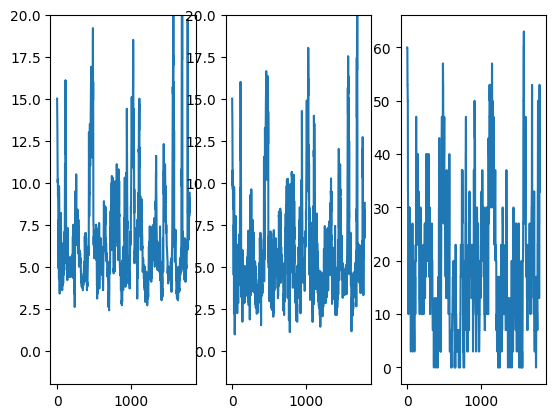

In [52]:
hrs = 30
fig, ax = plt.subplots(ncols=3)
ax[0].plot(var_df["Bt"][:hrs*60])
ax[1].plot(np.sum(var_df[["Bx", "By", "Bz"]].iloc[:hrs*60]**2, axis=1)**0.5)
ax[2].plot(var_df["Kp"].iloc[:hrs*60])
ax[0].set_ylim(-2, 20)
ax[1].set_ylim(-2, 20)

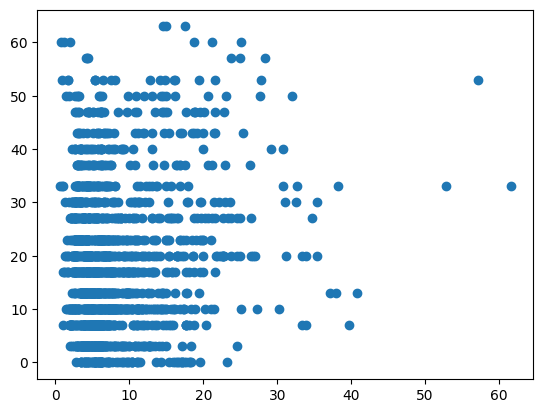

In [53]:
plt.scatter(var_df["SWPD"][:hrs*60], var_df["Kp"].iloc[:hrs*60])